In [329]:
local = True
train_ratio = 0.7
iter_cnt = 100
checkpoint = 1
# memory issue
input_size = 5000

In [330]:
if local:
    %matplotlib inline
import matplotlib
if not local:
    matplotlib.use('Agg')
import pandas as pd
import math
import os
import seaborn as sns
import collections
import matplotlib.pyplot as plt
import numpy as np
import keras.layers as KL
import keras.optimizers as KO
import keras.models as KM
import keras.backend as K

In [331]:
train_raw_path = 'data/train.tsv' if local else '/data/train.tsv'
train_raw = pd.read_csv(train_raw_path, sep='\t')

In [332]:
print('input length: ', len(train_raw))
for k in train_raw.keys():
    print(k)

input length:  1482535
train_id
name
item_condition_id
category_name
brand_name
price
shipping
item_description


In [333]:
test_raw_path = 'data/test.tsv' if local else '/data/test.tsv'
test_raw = pd.read_csv(test_raw_path, sep='\t')

In [334]:
train_brand_list = list(set(train_raw['brand_name']))
test_brand_list = list(set(test_raw['brand_name']))
print('training brand size: ', len(train_brand_list))
print('testing brand size: ', len(test_brand_list))
print('common brand size: ', len(list(set(train_brand_list)&set(test_brand_list))))
total_brand_list = list(set(train_brand_list)|set(test_brand_list))
brand_dict = {}
for b in total_brand_list:
    brand_dict[b] = len(brand_dict)
print('brand dict size: ', len(brand_dict))

training brand size:  4810
testing brand size:  3901
common brand size:  3421
brand dict size:  5290


In [335]:
total_category = []
total_category.extend(train_raw['category_name'].tolist())
total_category.extend(test_raw['category_name'].tolist())
print('total category count: ', len(total_category))
dicts = []
for c in total_category:
    if type(c) == str:
        clist = c.split('/')
        level_of_category = len(clist)
        while level_of_category > len(dicts):
            dicts.append({})
        for i in range(level_of_category):
            current = clist[i]
            if current not in dicts[i]:
                dicts[i][current] = len(dicts[i])
print('level of dicts: ', len(dicts))

total category count:  2175894
level of dicts:  5


In [336]:
train_raw_size = len(train_raw)
start = np.random.randint(train_raw_size - input_size)
end = start + input_size
train_raw = train_raw[start:end]

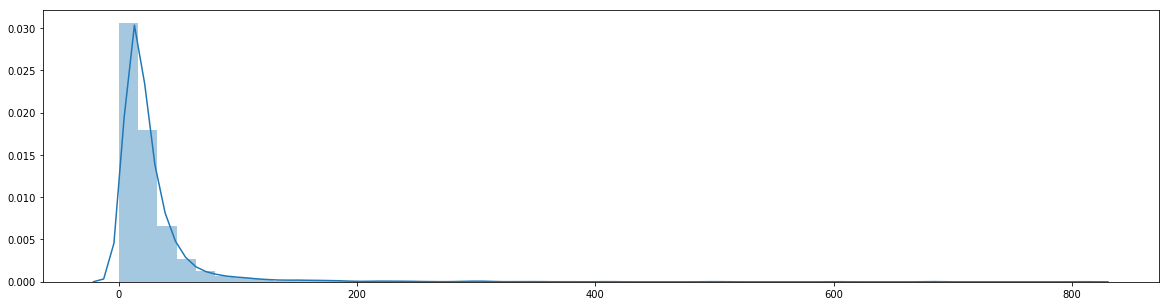

In [337]:
plt.figure(figsize=(20,5))
sns.distplot(train_raw['price'].tolist())
if not local:
    plt.savefig('/output/price_distribution.png')
else:
    plt.show()

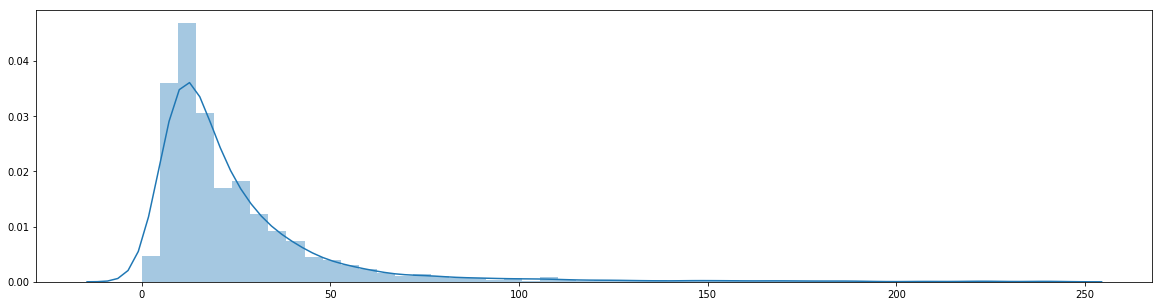

In [338]:
low_price = []
limit = 250
for p in train_raw['price'].tolist():
    if p < limit:
        low_price.append(p)
plt.figure(figsize=(20,5))
sns.distplot(low_price)
if not local:
    plt.savefig('/output/low_price_distribution.png')
else:
    plt.show()

In [339]:
print('low price range: ', len(low_price))
print('high price range: ', len(train_raw['price'].tolist()) - len(low_price))

low price range:  4971
high price range:  29


In [340]:
for i in range(len(dicts)):
    print('level ', i, ' dict size: ', len(dicts[i]))

level  0  dict size:  10
level  1  dict size:  113
level  2  dict size:  882
level  3  dict size:  6
level  4  dict size:  2


In [341]:
def encode_category(data, dicts, level):
    res = []
    for d in data:
        row = []
        for lv in range(level):
            exrow = [0 for i in range(len(dicts[lv]))]
            if type(d) == str:
                clist = d.split('/')
                if lv < len(clist) and clist[lv] in dicts[lv]:
                    exrow[dicts[lv][clist[lv]]] = 1
            row.extend(exrow)
        res.append(row)
    output = np.array(res)
    return output

In [342]:
train_category = encode_category(train_raw['category_name'].tolist(), dicts, 2)

In [343]:
print('training category shape: ', train_category.shape)

training category shape:  (5000, 123)


In [344]:
total_item_condition = []
total_item_condition.extend(train_raw['item_condition_id'])
total_item_condition.extend(test_raw['item_condition_id'])
print('total item condition id count: ', len(total_item_condition))
print(list(set(total_item_condition)))
condition_list = list(set(total_item_condition))
condition_dict = {}
for i in range(len(condition_list)):
    condition_dict[condition_list[i]] = i
print('condition dict: ', condition_dict)

total item condition id count:  698359
[1, 2, 3, 4, 5]
condition dict:  {1: 0, 2: 1, 3: 2, 4: 3, 5: 4}


In [345]:
def encode_condition(data, condition_dict):
    res = []
    for d in data:
        row = np.zeros((len(condition_dict)))
        row[condition_dict[d]] = 1
        res.append(row)
    output = np.array(res)
    return output

In [346]:
train_condition = encode_condition(train_raw['item_condition_id'], condition_dict)

In [347]:
print('training condition shape: ', train_condition.shape)

training condition shape:  (5000, 5)


In [348]:
def encode_shipping(data):
    res = [[i] for i in data]
    output = np.array(res)
    return output

In [349]:
train_shipping = encode_shipping(train_raw['shipping'])

In [350]:
print('training shipping shape: ', train_shipping.shape)

training shipping shape:  (5000, 1)


In [351]:
def encode_brand(data, brand_dict):
    res = []
    for d in data:
        row = np.zeros((len(brand_dict)))
        if d in brand_dict:
            row[brand_dict[d]] = 1
        res.append(row)
    output = np.array(res)
    return output

In [352]:
train_brand = encode_brand(train_raw['brand_name'], brand_dict)

In [353]:
print('training brand shape: ', train_brand.shape)

training brand shape:  (5000, 5290)


In [377]:
train_price = np.array([[i] for i in train_raw['price']])

In [378]:
print('price shape: ', train_price.shape)

price shape:  (5000, 1)


In [356]:
def get_price_range(price):
    res = 0
    if price < 100:
        res = price // 10
    elif price < 500:
        res = (100 // 10) + 1 + (price - 100) // 50
    else:
        res = (100 // 10) + 1 + ((500 - 100) // 50) + 1 + (price - 500) // 100
    return int(res)

In [357]:
def encode_price_category(data):
    max_price = 2250
    category_size = get_price_range(max_price) + 1
    print('maximum price is: ', max_price, ', total ', category_size, ' categories')
    res = []
    for d in data:
        row = np.zeros((category_size))
        row[get_price_range(d)] = 1
        res.append(row)
    output = np.array(res)
    return output

In [358]:
train_price_category = encode_price_category(train_raw['price'].tolist())

maximum price is:  2250 , total  38  categories


In [359]:
print('train price category shape: ', train_price_category.shape)

train price category shape:  (5000, 38)


In [360]:
train_condition = np.hstack([train_condition, train_shipping])

In [361]:
print('condition feature shape: ', train_condition.shape)

condition feature shape:  (5000, 6)


In [362]:
train_size = round(train_ratio * len(train_raw['price'].tolist()))
x_train_brand = train_brand[:train_size]
print('x_train_brand shape: ', x_train_brand.shape)
x_test_brand = train_brand[train_size:]
print('x_test_brand shape: ', x_test_brand.shape)
y_train_brand = train_price_category[:train_size]
print('y_train_brand shape: ', y_train_brand.shape)
y_test_brand = train_price_category[train_size:]
print('y_test_brand shape: ', y_test_brand.shape)
x_train_category = train_category[:train_size]
print('x_train_category shape: ', x_train_category.shape)
x_test_category = train_category[train_size:]
print('x_test_category shape: ', x_test_category.shape)
y_train_category = train_price_category[:train_size]
print('y_train_category shape: ', y_train_category.shape)
y_test_category = train_price_category[train_size:]
print('y_test_category shape: ', y_test_category.shape)
x_train_condition = train_condition[:train_size]
print('x_train_condition shape: ', x_train_condition.shape)
x_test_condition = train_condition[train_size:]
print('x_test_condition shape: ', x_test_condition.shape)
y_train_condition = train_price[:train_size]
print('y_train_condition shape: ', y_train_condition.shape)
y_test_condition = train_price[train_size:]
print('y_test_condition shape: ', y_test_condition.shape)

x_train_brand shape:  (3500, 5290)
x_test_brand shape:  (1500, 5290)
y_train_brand shape:  (3500, 38)
y_test_brand shape:  (1500, 38)
x_train_category shape:  (3500, 123)
x_test_category shape:  (1500, 123)
y_train_category shape:  (3500, 38)
y_test_category shape:  (1500, 38)
x_train_condition shape:  (3500, 6)
x_test_condition shape:  (1500, 6)
y_train_condition shape:  (3500, 1)
y_test_condition shape:  (1500, 1)


In [363]:
# brand portion
brand_inputs = KL.Input(shape=(x_train_brand.shape[1],))
brand_dnn_1 = KL.Dense(units=128, activation='relu')
x_brand = brand_dnn_1(brand_inputs)
x_brand = KL.Dropout(0.2)(x_brand)
brand_output_layer = KL.Dense(units=y_train_brand.shape[1], activation='softmax')
brand_outputs = brand_output_layer(x_brand)
# category portion
category_inputs = KL.Input(shape=(x_train_category.shape[1],))
category_dnn_1 = KL.Dense(units=128, activation='relu')
x_category = category_dnn_1(category_inputs)
x_category = KL.Dropout(0.2)(x_category)
category_output_layer = KL.Dense(units=y_train_category.shape[1], activation='softmax')
category_outputs = category_output_layer(x_category)
# condition portion
condition_inputs = KL.Input(shape=(x_train_condition.shape[1],))
x_condition = KL.Dense(128, activation='relu')(condition_inputs)
x_condition = KL.Dropout(0.2)(x_condition)
condition_outputs = KL.Dense(16)(x_condition)
# combine portion
x_combine = KL.concatenate([brand_outputs, category_outputs, condition_outputs], axis=-1)
x_combine = KL.Dense(128, activation='relu')(x_combine)
x_combine = KL.Dropout(0.2)(x_combine)
final_outputs = KL.Dense(y_train_condition.shape[1], activation='relu')(x_combine)

In [364]:
brand_model = KM.Model(inputs=brand_inputs, outputs=brand_outputs)
brand_model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
if os.path.isfile('brand_model.h5'):
    brand_model.load_weights('brand_model.h5')

In [365]:
brand_train_losses = []
brand_train_acc = []
brand_test_losses = []
brand_test_acc = []
for i in range(iter_cnt):
    H = brand_model.fit(x=x_train_brand, y=y_train_brand, verbose=0)
    brand_train_losses.extend(H.history['loss'])
    brand_train_acc.extend(H.history['acc'])
    if (i+1) % checkpoint == 0:
        score = brand_model.evaluate(x=x_test_brand, y=y_test_brand, verbose=0)
        brand_test_losses.append(score[0])
        brand_test_acc.append(score[1])
        print(i+1, '/', iter_cnt)

1 / 100
2 / 100
3 / 100
4 / 100
5 / 100
6 / 100
7 / 100
8 / 100
9 / 100
10 / 100
11 / 100
12 / 100
13 / 100
14 / 100
15 / 100
16 / 100
17 / 100
18 / 100
19 / 100
20 / 100
21 / 100
22 / 100
23 / 100
24 / 100
25 / 100
26 / 100
27 / 100
28 / 100
29 / 100
30 / 100
31 / 100
32 / 100
33 / 100
34 / 100
35 / 100
36 / 100
37 / 100
38 / 100
39 / 100
40 / 100
41 / 100
42 / 100
43 / 100
44 / 100
45 / 100
46 / 100
47 / 100
48 / 100
49 / 100
50 / 100
51 / 100
52 / 100
53 / 100
54 / 100
55 / 100
56 / 100
57 / 100
58 / 100
59 / 100
60 / 100
61 / 100
62 / 100
63 / 100
64 / 100
65 / 100
66 / 100
67 / 100
68 / 100
69 / 100
70 / 100
71 / 100
72 / 100
73 / 100
74 / 100
75 / 100
76 / 100
77 / 100
78 / 100
79 / 100
80 / 100
81 / 100
82 / 100
83 / 100
84 / 100
85 / 100
86 / 100
87 / 100
88 / 100
89 / 100
90 / 100
91 / 100
92 / 100
93 / 100
94 / 100
95 / 100
96 / 100
97 / 100
98 / 100
99 / 100
100 / 100


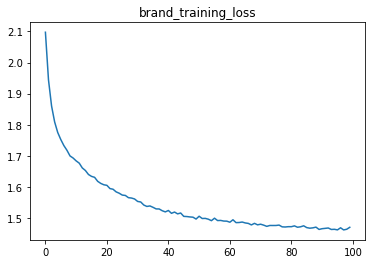

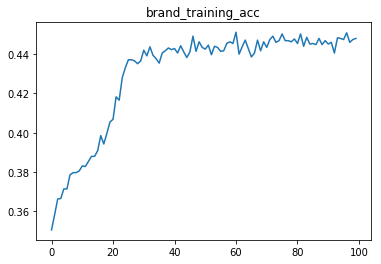

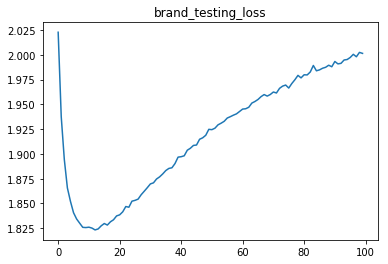

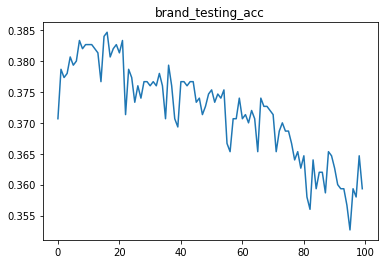

In [366]:
plt.figure()
plt.plot(brand_train_losses)
plt.title('brand_training_loss')
if not local:
    plt.savefig('/output/brand_training_loss.png')
else:
    plt.show()
plt.figure()
plt.plot(brand_train_acc)
plt.title('brand_training_acc')
if not local:
    plt.savefig('/output/brand_training_acc.png')
else:
    plt.show()
plt.figure()
plt.plot(brand_test_losses)
plt.title('brand_testing_loss')
if not local:
    plt.savefig('/output/brand_testing_loss.png')
else:
    plt.show()
plt.figure()
plt.plot(brand_test_acc)
plt.title('brand_testing_acc')
if not local:
    plt.savefig('/output/brand_testing_acc.png')
else:
    plt.show()

In [367]:
category_model = KM.Model(inputs=category_inputs, outputs=category_outputs)
category_model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
if os.path.isfile('category_model.h5'):
    category_model.load_weights('category_model.h5')

In [368]:
category_train_losses = []
category_train_acc = []
category_test_losses = []
category_test_acc = []
for i in range(iter_cnt):
    H = category_model.fit(x=x_train_category, y=y_train_category, verbose=0)
    category_train_losses.extend(H.history['loss'])
    category_train_acc.extend(H.history['acc'])
    if (i+1) % checkpoint == 0:
        score = category_model.evaluate(x=x_test_category, y=y_test_category, verbose=0)
        category_test_losses.append(score[0])
        category_test_acc.append(score[1])
        print(i+1, '/', iter_cnt)

1 / 100
2 / 100
3 / 100
4 / 100
5 / 100
6 / 100
7 / 100
8 / 100
9 / 100
10 / 100
11 / 100
12 / 100
13 / 100
14 / 100
15 / 100
16 / 100
17 / 100
18 / 100
19 / 100
20 / 100
21 / 100
22 / 100
23 / 100
24 / 100
25 / 100
26 / 100
27 / 100
28 / 100
29 / 100
30 / 100
31 / 100
32 / 100
33 / 100
34 / 100
35 / 100
36 / 100
37 / 100
38 / 100
39 / 100
40 / 100
41 / 100
42 / 100
43 / 100
44 / 100
45 / 100
46 / 100
47 / 100
48 / 100
49 / 100
50 / 100
51 / 100
52 / 100
53 / 100
54 / 100
55 / 100
56 / 100
57 / 100
58 / 100
59 / 100
60 / 100
61 / 100
62 / 100
63 / 100
64 / 100
65 / 100
66 / 100
67 / 100
68 / 100
69 / 100
70 / 100
71 / 100
72 / 100
73 / 100
74 / 100
75 / 100
76 / 100
77 / 100
78 / 100
79 / 100
80 / 100
81 / 100
82 / 100
83 / 100
84 / 100
85 / 100
86 / 100
87 / 100
88 / 100
89 / 100
90 / 100
91 / 100
92 / 100
93 / 100
94 / 100
95 / 100
96 / 100
97 / 100
98 / 100
99 / 100
100 / 100


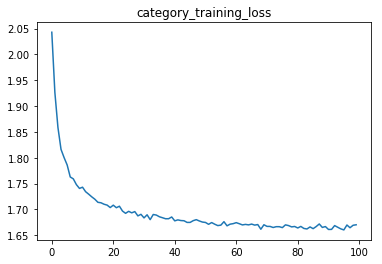

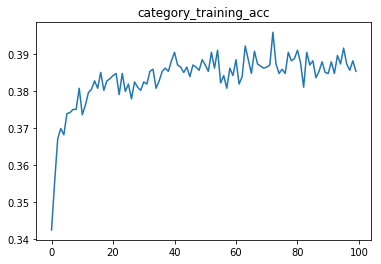

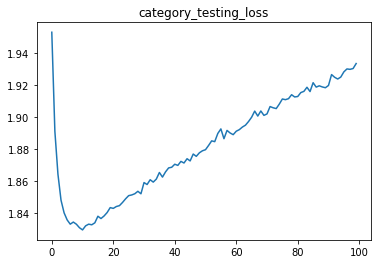

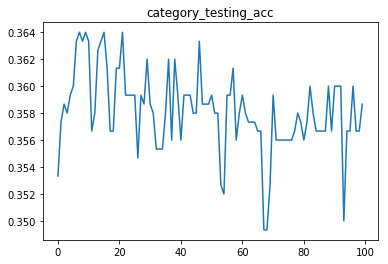

In [369]:
plt.figure()
plt.plot(category_train_losses)
plt.title('category_training_loss')
if not local:
    plt.savefig('/output/category_training_loss.png')
else:
    plt.show()
plt.figure()
plt.plot(category_train_acc)
plt.title('category_training_acc')
if not local:
    plt.savefig('/output/category_training_acc.png')
else:
    plt.show()
plt.figure()
plt.plot(category_test_losses)
plt.title('category_testing_loss')
if not local:
    plt.savefig('/output/category_testing_loss.png')
else:
    plt.show()
plt.figure()
plt.plot(category_test_acc)
plt.title('category_testing_acc')
if not local:
    plt.savefig('/output/category_testing_acc.png')
else:
    plt.show()

In [370]:
brand_dnn_1.trainable = False
brand_output_layer.trainable = False
category_dnn_1.trainable = False
category_output_layer.trainable = False
combined_model = KM.Model(inputs=[brand_inputs, category_inputs, condition_inputs], outputs=[final_outputs])
combined_model.compile(optimizer='rmsprop', loss='mean_squared_error')
if os.path.isfile('combined_model.h5'):
    combined_model.load_weights('combined_model.h5')

In [371]:
combined_train_losses = []
combined_test_losses = []
for i in range(iter_cnt):
    H = combined_model.fit(x=[x_train_brand, x_train_category, x_train_condition], y=y_train_condition, verbose=0)
    combined_train_losses.extend(H.history['loss'])
    if (i+1) % checkpoint == 0:
        score = combined_model.evaluate(x=[x_test_brand, x_test_category, x_test_condition], 
                                        y=y_test_condition, verbose=0)
        combined_test_losses.append(score)
        print(i+1, '/', iter_cnt)

1 / 100
2 / 100
3 / 100
4 / 100
5 / 100
6 / 100
7 / 100
8 / 100
9 / 100
10 / 100
11 / 100
12 / 100
13 / 100
14 / 100
15 / 100
16 / 100
17 / 100
18 / 100
19 / 100
20 / 100
21 / 100
22 / 100
23 / 100
24 / 100
25 / 100
26 / 100
27 / 100
28 / 100
29 / 100
30 / 100
31 / 100
32 / 100
33 / 100
34 / 100
35 / 100
36 / 100
37 / 100
38 / 100
39 / 100
40 / 100
41 / 100
42 / 100
43 / 100
44 / 100
45 / 100
46 / 100
47 / 100
48 / 100
49 / 100
50 / 100
51 / 100
52 / 100
53 / 100
54 / 100
55 / 100
56 / 100
57 / 100
58 / 100
59 / 100
60 / 100
61 / 100
62 / 100
63 / 100
64 / 100
65 / 100
66 / 100
67 / 100
68 / 100
69 / 100
70 / 100
71 / 100
72 / 100
73 / 100
74 / 100
75 / 100
76 / 100
77 / 100
78 / 100
79 / 100
80 / 100
81 / 100
82 / 100
83 / 100
84 / 100
85 / 100
86 / 100
87 / 100
88 / 100
89 / 100
90 / 100
91 / 100
92 / 100
93 / 100
94 / 100
95 / 100
96 / 100
97 / 100
98 / 100
99 / 100
100 / 100


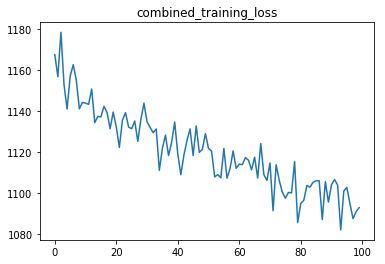

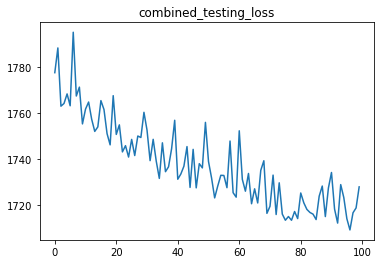

In [372]:
plt.figure()
plt.plot(combined_train_losses)
plt.title('combined_training_loss')
if not local:
    plt.savefig('/output/combined_training_loss.png')
else:
    plt.show()
plt.figure()
plt.plot(combined_test_losses)
plt.title('combined_testing_loss')
if not local:
    plt.savefig('/output/combined_testing_loss.png')
else:
    plt.show()

In [373]:
predictions = combined_model.predict(x=[x_test_brand, x_test_category, x_test_condition], verbose=1)

1500/1500 [==============================] - 1s 357us/step


In [374]:
for i in range(5):
    print('truth: ', y_test_condition[i][0], ', prediction: ', predictions[i][0])

truth:  14.0 , prediction:  29.4689
truth:  19.0 , prediction:  28.0847
truth:  30.0 , prediction:  38.4485
truth:  9.0 , prediction:  27.4602
truth:  10.0 , prediction:  24.4312


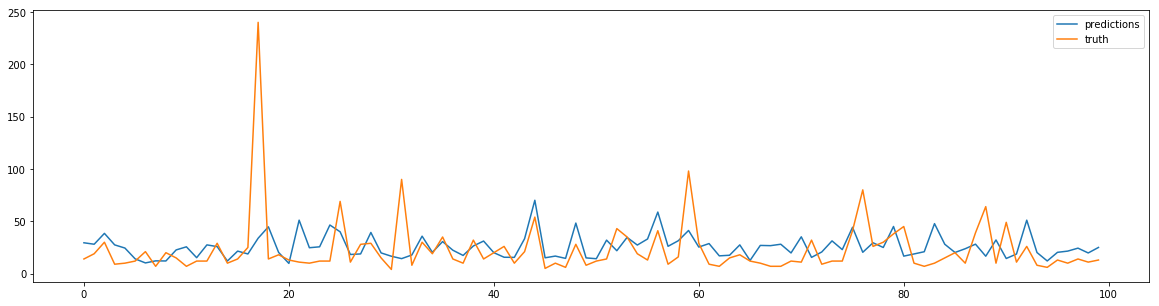

In [375]:
pred_arr = sum(predictions.tolist()[:100], [])
truth_arr = sum(y_test_condition.tolist()[:100], [])
plt.figure(figsize=(20,5))
plt.plot(pred_arr, label='predictions')
plt.plot(truth_arr, label='truth')
plt.legend()
if not local:
    plt.savefig('/output/truth_vs_predictions.png')
else:
    plt.show()

In [376]:
brand_model.save_weights('brand_model.h5')
category_model.save_weights('category_model.h5')
combined_model.save_weights('combined_model.h5')
combined_model.save('complete_model.h5')